In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import nn_helper module
import helper
%aimport helper

helper = helper.HELPER('train')

import seaborn; seaborn.set()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout , Flatten
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# get the AAPL Adj Close data and visualize the return

In [4]:
ticker = "AAPL"
index_ticker = "SPY"
dateAttr = "Dt"
priceAttr = ['Adj Close']

data = helper.getData([ticker], index_ticker, priceAttr).iloc[:, :1]
data

,AAPL_Adj_Close
Dt,
2000-01-03,3.4785
2000-01-04,3.1852
2000-01-05,3.2318
2000-01-06,2.9521
2000-01-07,3.0920
...,...
2016-12-23,111.3073
2016-12-27,112.0142
2016-12-28,111.5366


In [5]:
ret = data.pct_change().dropna()
ret

,AAPL_Adj_Close
Dt,
2000-01-04,-0.084318
2000-01-05,0.014630
2000-01-06,-0.086546
2000-01-07,0.047390
2000-01-10,-0.017594
...,...
2016-12-23,0.001978
2016-12-27,0.006351
2016-12-28,-0.004264


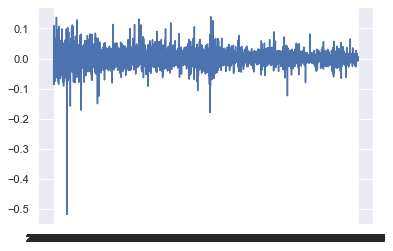

In [4]:
plt.plot(ret.iloc[:, 0])

In [6]:
ret[ret['AAPL_Adj_Close'] < -0.5]

,AAPL_Adj_Close
Dt,
2000-09-29,-0.518677


# the extreme outlier is obtained, and will be removed from all the dataframe later trainning part

In [7]:
ret = ret.drop('2000-09-29', axis = 0)
ret

,AAPL_Adj_Close
Dt,
2000-01-04,-0.084318
2000-01-05,0.014630
2000-01-06,-0.086546
2000-01-07,0.047390
2000-01-10,-0.017594
...,...
2016-12-23,0.001978
2016-12-27,0.006351
2016-12-28,-0.004264


# retrieve all the stock data to predict AAPL return

In [25]:
train_dir = './Data/train/'
csv_list = os.listdir(train_dir)
stock_list = [i.split('.')[0] for i in csv_list]
print(stock_list)
new_list = []

['AAPL', 'ACN', 'ADBE', 'CRM', 'CSCO', 'FB', 'GOOG', 'IBM', 'INTC', 'MA', 'MSFT', 'NVDA', 'SPY', 'V', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY']


In [26]:
for x in stock_list:
    df = pd.read_csv(train_dir + x + '.csv').set_index("Dt")
    df.drop(['Factor', 'Div'], axis=1, inplace=True)
    coverage = len(df.dropna()) / len(df)
    if coverage != 1:
        print((x, coverage))
        continue
    new_list.append(x)

('ACN', 0.9090483984101005)
('CRM', 0.7376665887304186)
('FB', 0.27191956979191023)
('GOOG', 0.7283142389525368)
('MA', 0.624269347673603)
('V', 0.5176525602057517)
('XLRE', 0.07271451952303017)


In [27]:
data3 = pd.read_csv(train_dir + 'AAPL' + '.csv').set_index("Dt")
data3.drop(['Factor', 'Div'], axis=1, inplace=True)
for x in new_list[1:]:
    df = pd.read_csv(train_dir + x + '.csv').set_index("Dt")
    df.drop(['Factor', 'Div'], axis=1, inplace=True)
    data3 = data3.join(df, how='left', rsuffix='_' + x)
data3.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Adj Close_ADBE',
       'Close_ADBE', 'High_ADBE', 'Low_ADBE',
       ...
       'High_XLV', 'Low_XLV', 'Open_XLV', 'Volume_XLV', 'Adj Close_XLY',
       'Close_XLY', 'High_XLY', 'Low_XLY', 'Open_XLY', 'Volume_XLY'],
      dtype='object', length=102)

In [28]:
for column in data3.columns:
    if len(column.split('_')) < 2:
        data3.rename(columns={column: column + '_AAPL'}, inplace=True)
data3

,Adj Close_AAPL,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL,Adj Close_ADBE,Close_ADBE,High_ADBE,Low_ADBE,...,High_XLV,Low_XLV,Open_XLV,Volume_XLV,Adj Close_XLY,Close_XLY,High_XLY,Low_XLY,Open_XLY,Volume_XLY
Dt,,,,,,,,,,,,,,,,,,,,,
2000-01-03,3.4785,111.938,112.5000,101.688,104.8750,133949200.0,16.2747,65.563,67.500,64.250,...,31.000,30.063,31.000,246700.0,23.6030,30.125,31.0000,29.8590,31.000,212900.0
2000-01-04,3.1852,102.500,110.6250,101.188,108.2500,128094400.0,14.9094,60.063,65.813,59.938,...,30.203,29.531,30.188,35300.0,22.8930,29.219,29.8130,29.0310,29.688,177200.0
2000-01-05,3.2318,104.000,110.5630,103.000,103.7500,194580400.0,15.2042,61.250,62.750,58.250,...,29.781,29.219,29.781,137600.0,22.6114,28.859,29.3461,28.7190,29.344,124600.0
2000-01-06,2.9521,95.000,107.0000,95.000,106.1183,191993200.0,15.3283,61.750,62.625,60.625,...,29.563,29.156,29.313,50000.0,22.8685,29.188,29.4060,28.9991,29.047,135800.0
2000-01-07,3.0920,99.500,101.0000,95.500,96.5000,115183600.0,16.0730,64.750,64.750,60.875,...,29.797,29.359,29.469,22100.0,23.9458,30.563,30.5630,29.5000,29.500,70000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,111.3073,116.520,116.5255,115.590,115.5900,14249500.0,105.0200,105.020,105.420,104.610,...,69.500,68.960,68.960,4188700.0,79.5679,82.450,82.7650,82.3510,82.610,2837000.0
2016-12-27,112.0142,117.260,117.8000,116.490,116.5200,18296900.0,104.9800,104.980,105.900,104.860,...,70.000,69.530,69.550,5141200.0,79.8767,82.770,83.1000,82.5100,82.510,6101100.0
2016-12-28,111.5366,116.760,118.0170,116.200,117.5200,20905900.0,103.7700,103.770,105.160,103.500,...,69.750,69.060,69.670,4558800.0,79.3267,82.200,83.0300,82.1800,82.950,3857700.0


In [29]:
for i in range(len(data3.columns)):
    data3.iloc[:, i] = data3.iloc[:, i].pct_change()
data3.dropna(inplace=True)
data3['AAPL_Adj_Return'] = data3['Adj Close_AAPL']
data3

,Adj Close_AAPL,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL,Adj Close_ADBE,Close_ADBE,High_ADBE,Low_ADBE,...,Low_XLV,Open_XLV,Volume_XLV,Adj Close_XLY,Close_XLY,High_XLY,Low_XLY,Open_XLY,Volume_XLY,AAPL_Adj_Return
Dt,,,,,,,,,,,,,,,,,,,,,
2000-01-04,-0.084318,-0.084315,-0.016667,-0.004917,0.032181,-0.043709,-0.083891,-0.083889,-0.024993,-0.067113,...,-0.017696,-0.026194,-0.856911,-0.030081,-0.030075,-0.038290,-0.027730,-0.042323,-0.167684,-0.084318
2000-01-05,0.014630,0.014634,-0.000560,0.017907,-0.041570,0.519039,0.019773,0.019763,-0.046541,-0.028162,...,-0.010565,-0.013482,2.898017,-0.012301,-0.012321,-0.015661,-0.010747,-0.011587,-0.296840,0.014630
2000-01-06,-0.086546,-0.086538,-0.032226,-0.077670,0.022827,-0.013296,0.008162,0.008163,-0.001992,0.040773,...,-0.002156,-0.015715,-0.636628,0.011370,0.011400,0.002041,0.009753,-0.010121,0.089888,-0.086546
2000-01-07,0.047390,0.047368,-0.056075,0.005263,-0.090638,-0.400064,0.048583,0.048583,0.033932,0.004124,...,0.006963,0.005322,-0.558000,0.047108,0.047108,0.039346,0.017273,0.015595,-0.484536,0.047390
2000-01-10,-0.017594,-0.017588,0.012376,-0.007853,0.056995,0.096215,0.038611,0.038610,0.038610,0.045175,...,0.077182,0.094370,0.438914,-0.005112,-0.005137,0.001014,0.022237,0.035010,-0.401429,-0.017594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,0.001978,0.001978,0.000133,-0.000432,-0.006532,-0.453747,0.002865,0.002865,0.002615,0.006349,...,0.007009,0.002909,-0.060493,-0.002178,-0.002178,-0.007733,-0.001746,-0.009235,-0.364044,0.001978
2016-12-27,0.006351,0.006351,0.010938,0.007786,0.008046,0.284038,-0.000381,-0.000381,0.004553,0.002390,...,0.008266,0.008556,0.227398,0.003881,0.003881,0.004048,0.001931,-0.001211,1.150546,0.006351
2016-12-28,-0.004264,-0.004264,0.001842,-0.002489,0.008582,0.142592,-0.011526,-0.011526,-0.006988,-0.012970,...,-0.006760,0.001725,-0.113281,-0.006886,-0.006887,-0.000842,-0.004000,0.005333,-0.367704,-0.004264


In [30]:
#drop the extreme negative return in AAPL
data3 = data3.drop('2000-09-29', axis = 0)
data3

,Adj Close_AAPL,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL,Adj Close_ADBE,Close_ADBE,High_ADBE,Low_ADBE,...,Low_XLV,Open_XLV,Volume_XLV,Adj Close_XLY,Close_XLY,High_XLY,Low_XLY,Open_XLY,Volume_XLY,AAPL_Adj_Return
Dt,,,,,,,,,,,,,,,,,,,,,
2000-01-04,-0.084318,-0.084315,-0.016667,-0.004917,0.032181,-0.043709,-0.083891,-0.083889,-0.024993,-0.067113,...,-0.017696,-0.026194,-0.856911,-0.030081,-0.030075,-0.038290,-0.027730,-0.042323,-0.167684,-0.084318
2000-01-05,0.014630,0.014634,-0.000560,0.017907,-0.041570,0.519039,0.019773,0.019763,-0.046541,-0.028162,...,-0.010565,-0.013482,2.898017,-0.012301,-0.012321,-0.015661,-0.010747,-0.011587,-0.296840,0.014630
2000-01-06,-0.086546,-0.086538,-0.032226,-0.077670,0.022827,-0.013296,0.008162,0.008163,-0.001992,0.040773,...,-0.002156,-0.015715,-0.636628,0.011370,0.011400,0.002041,0.009753,-0.010121,0.089888,-0.086546
2000-01-07,0.047390,0.047368,-0.056075,0.005263,-0.090638,-0.400064,0.048583,0.048583,0.033932,0.004124,...,0.006963,0.005322,-0.558000,0.047108,0.047108,0.039346,0.017273,0.015595,-0.484536,0.047390
2000-01-10,-0.017594,-0.017588,0.012376,-0.007853,0.056995,0.096215,0.038611,0.038610,0.038610,0.045175,...,0.077182,0.094370,0.438914,-0.005112,-0.005137,0.001014,0.022237,0.035010,-0.401429,-0.017594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,0.001978,0.001978,0.000133,-0.000432,-0.006532,-0.453747,0.002865,0.002865,0.002615,0.006349,...,0.007009,0.002909,-0.060493,-0.002178,-0.002178,-0.007733,-0.001746,-0.009235,-0.364044,0.001978
2016-12-27,0.006351,0.006351,0.010938,0.007786,0.008046,0.284038,-0.000381,-0.000381,0.004553,0.002390,...,0.008266,0.008556,0.227398,0.003881,0.003881,0.004048,0.001931,-0.001211,1.150546,0.006351
2016-12-28,-0.004264,-0.004264,0.001842,-0.002489,0.008582,0.142592,-0.011526,-0.011526,-0.006988,-0.012970,...,-0.006760,0.001725,-0.113281,-0.006886,-0.006887,-0.000842,-0.004000,0.005333,-0.367704,-0.004264


# Model building -Single Layer

In [54]:
model2 = Sequential()
model2.add(LSTM(48, activation='relu', return_sequences=False, input_shape=(500, len(data3.columns)),
                kernel_initializer=tf.constant_initializer(0.02),
                bias_initializer=tf.constant_initializer(0.02)))
model2.add(Dropout(0.5))
model2.add(Dense(24, activation='relu', kernel_initializer=tf.constant_initializer(0.02),
                bias_initializer=tf.constant_initializer(0.02)))
model2.add(Dropout(0.3))
model2.add(Dense(16, activation='relu', kernel_initializer=tf.constant_initializer(0.02),
                bias_initializer=tf.constant_initializer(0.02)))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation='linear', kernel_initializer=tf.constant_initializer(0.03),
                bias_initializer=tf.constant_initializer(0.03)))


model2.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_4752/2799846883.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model2.fit_generator(train_data_gen,


Epoch 1/20
28/28 [==============================] - 2s 25ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 6.9206e-04 - val_mse: 6.9206e-04
Epoch 2/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 3.7309e-04 - val_mse: 3.7309e-04
Epoch 3/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 3.2509e-04 - val_mse: 3.2509e-04
Epoch 4/20
28/28 [==============================] - 0s 17ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 3.1987e-04 - val_mse: 3.1987e-04
Epoch 5/20
28/28 [==============================] - 0s 17ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 3.1986e-04 - val_mse: 3.1986e-04
Epoch 6/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 3.1996e-04 - val_mse: 3.1996e-04
Epoch 7/20
28/28 [==============================] - 1s 21ms/step - loss: 9.8998e-04 - mse: 9.8998e-04 - val_loss: 3.1993e-04 - val_mse: 3.1993e-04
Epoch 8/20
28/28 [=

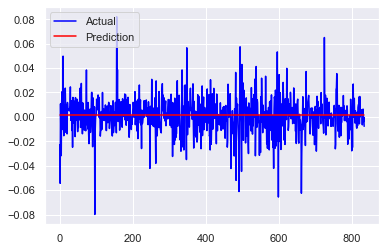

In [55]:
X = np.array(data3.iloc[:, :])
y = np.array(data3.iloc[:, -1:])

look_back = 20
batch_size = 100

X_train0, X_test, y_train0, y_test = train_test_split(X, y,
                                            train_size=0.8, 
                                            shuffle=False)

X_train, X_val , y_train, y_val = train_test_split(X_train0, y_train0,
                                            train_size=0.8, 
                                            shuffle=False)

train_data_gen = TimeseriesGenerator(X_train, y_train, length=look_back, batch_size=batch_size)
val_data_gen = TimeseriesGenerator(X_val, y_val, length=look_back, batch_size=batch_size)
test_data_gen = TimeseriesGenerator(X_test, y_test, length=look_back, batch_size=batch_size)


history = model2.fit_generator(train_data_gen,
                                steps_per_epoch=len(train_data_gen),
                                epochs=20,
                                verbose=1,
                                validation_data=val_data_gen) 
    
    
y_pred_test = model2.predict(test_data_gen)
c = pd.concat([pd.DataFrame(y_pred_test), pd.DataFrame(y_test[look_back:])], axis=1)
c.columns = ['pred', 'actual']
pred = c.iloc[:, 0]
actual = c.iloc[:, 1]
plt.plot(actual, color='blue', label='Actual')
plt.plot(pred, color='red', label='Prediction')
plt.legend(loc='upper left')
plt.show()

# Model building -Multi Layer

In [14]:
model3 = Sequential()
model3.add(LSTM(48, activation='relu', return_sequences=True, input_shape=(20, len(data3.columns)), 
                kernel_initializer=tf.constant_initializer(0.02),
                bias_initializer=tf.constant_initializer(0.02)))
model3.add(LSTM(24, activation='relu', return_sequences=False, input_shape=(500, len(data3.columns)),
                kernel_initializer=tf.constant_initializer(0.02),
                bias_initializer=tf.constant_initializer(0.02)))
model3.add(Dropout(0.5))
model3.add(Dense(16, activation='relu', kernel_initializer=tf.constant_initializer(0.02),
                bias_initializer=tf.constant_initializer(0.02)))
model3.add(Dropout(0.3))
model3.add(Dense(8, activation='relu', kernel_initializer=tf.constant_initializer(0.02),
                bias_initializer=tf.constant_initializer(0.02)))
model3.add(Dropout(0.3))
model3.add(Dense(1, activation='linear', kernel_initializer=tf.constant_initializer(0.03),
                bias_initializer=tf.constant_initializer(0.03)))


model3.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

# Model fitting

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_4752/2309948747.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model3.fit_generator(train_data_gen,


Epoch 1/20
28/28 [==============================] - 4s 39ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 3.8176e-04 - val_mse: 3.8176e-04
Epoch 2/20
28/28 [==============================] - 1s 25ms/step - loss: 8.6911e-04 - mse: 8.6911e-04 - val_loss: 3.1986e-04 - val_mse: 3.1986e-04
Epoch 3/20
28/28 [==============================] - 1s 23ms/step - loss: 8.5738e-04 - mse: 8.5738e-04 - val_loss: 3.2010e-04 - val_mse: 3.2010e-04
Epoch 4/20
28/28 [==============================] - 1s 26ms/step - loss: 8.5597e-04 - mse: 8.5597e-04 - val_loss: 3.2088e-04 - val_mse: 3.2088e-04
Epoch 5/20
28/28 [==============================] - 1s 25ms/step - loss: 8.5669e-04 - mse: 8.5669e-04 - val_loss: 3.2067e-04 - val_mse: 3.2067e-04
Epoch 6/20
28/28 [==============================] - 1s 24ms/step - loss: 8.5634e-04 - mse: 8.5634e-04 - val_loss: 3.2042e-04 - val_mse: 3.2042e-04
Epoch 7/20
28/28 [==============================] - 1s 23ms/step - loss: 8.5619e-04 - mse: 8.5619e-04 - val_loss: 3.2100e-04 -

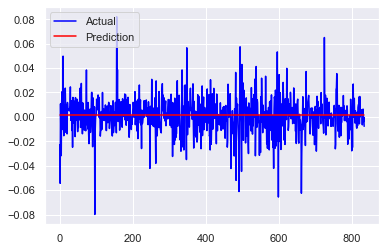

In [15]:
X = np.array(data3.iloc[:, :])
y = np.array(data3.iloc[:, -1:])

look_back = 20
batch_size = 100

X_train0, X_test, y_train0, y_test = train_test_split(X, y,
                                            train_size=0.8, 
                                            shuffle=False)

X_train, X_val , y_train, y_val = train_test_split(X_train0, y_train0,
                                            train_size=0.8, 
                                            shuffle=False)

train_data_gen = TimeseriesGenerator(X_train, y_train, length=look_back, batch_size=batch_size)
val_data_gen = TimeseriesGenerator(X_val, y_val, length=look_back, batch_size=batch_size)
test_data_gen = TimeseriesGenerator(X_test, y_test, length=look_back, batch_size=batch_size)


history = model3.fit_generator(train_data_gen,
                                steps_per_epoch=len(train_data_gen),
                                epochs=20,
                                verbose=1,
                                validation_data=val_data_gen) 
    
    
y_pred_test = model3.predict(test_data_gen)
c = pd.concat([pd.DataFrame(y_pred_test), pd.DataFrame(y_test[look_back:])], axis=1)
c.columns = ['pred', 'actual']
pred = c.iloc[:, 0]
actual = c.iloc[:, 1]
plt.plot(actual, color='blue', label='Actual')
plt.plot(pred, color='red', label='Prediction')
plt.legend(loc='upper left')
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error
# calculate MSE 
mse = mean_squared_error(actual,pred)
# calculate RMSE 
rmse = math.sqrt(mean_squared_error(actual, pred))

print('MSE: %.6f' % mse)
print('RMSE: %.6f' % rmse)

MSE: 0.000229
RMSE: 0.015127


## the prediction result is bad, it almost doesn't change

# use the most correlated stocks to predict AAPL returns

<AxesSubplot:>

Text(0.5, 1.0, 'Correlation matrix of returns')

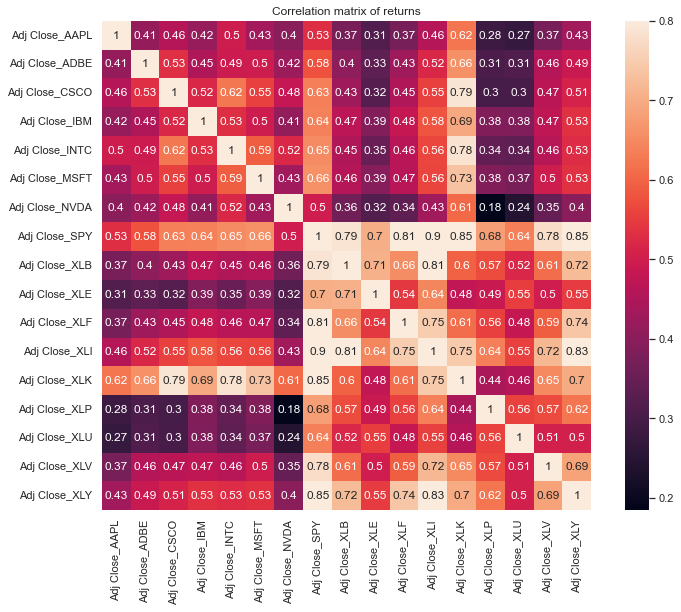

In [16]:
all_stocks = data3[['Adj Close_'+ stock for stock in new_list]]
cor_plot = all_stocks.corr()
f, ax = plt.subplots(figsize=(12, 9))
seaborn.heatmap(cor_plot, vmax=.8, square=True, annot=True);
plt.title('Correlation matrix of returns')

# use price data to predict AAPL future price first, and then calculate percent change to get AAPL future return

In [17]:
ticker = ["AAPL", "SPY"]
index_ticker = "XLY"
dateAttr = "Dt"
priceAttr = ["Adj Close", 'Volume', 'High', 'Low', 'Open']

data41 = helper.getData(ticker, index_ticker, priceAttr)
data41 = data41.join(data3[['Adj Close_CSCO', 'Adj Close_INTC']], how='left')
data41['AAPL Adj Close'] = data41['AAPL_Adj_Close']
data41 = data41.dropna()
data41

,AAPL_Adj_Close,AAPL_High,AAPL_Low,AAPL_Open,AAPL_Volume,SPY_Adj_Close,SPY_High,SPY_Low,SPY_Open,SPY_Volume,XLY_Adj_Close,XLY_High,XLY_Low,XLY_Open,XLY_Volume,Adj Close_CSCO,Adj Close_INTC,AAPL Adj Close
Dt,,,,,,,,,,,,,,,,,,
2000-01-04,3.1852,110.6250,101.188,108.2500,128094400.0,96.5415,144.0630,139.641,143.531,8089800.0,22.8930,29.8130,29.0310,29.6880,177200.0,-0.056102,-0.046695,3.1852
2000-01-05,3.2318,110.5630,103.000,103.7500,194580400.0,96.7142,141.5284,137.250,139.938,12177900.0,22.6114,29.3461,28.7190,29.3440,124600.0,-0.003065,0.008290,3.2318
2000-01-06,2.9521,107.0000,95.000,106.1183,191993200.0,95.1599,141.5000,137.750,139.625,6227200.0,22.8685,29.4060,28.9991,29.0470,135800.0,-0.016593,-0.058298,2.9521
2000-01-07,3.0920,101.0000,95.500,96.5000,115183600.0,100.6864,145.7500,140.063,140.313,8066500.0,23.9458,30.5630,29.5000,29.5000,70000.0,0.058751,0.041270,3.0920
2000-01-10,3.0376,102.2500,94.750,102.0000,126266000.0,101.0318,146.9060,145.031,146.250,5741700.0,23.8234,30.5940,30.1560,30.5328,41900.0,0.037189,0.045732,3.0376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,111.3073,116.5255,115.590,115.5900,14249500.0,214.2890,225.7200,225.210,225.430,36697800.0,79.5679,82.7650,82.3510,82.6100,2837000.0,0.002299,0.001083,111.3073
2016-12-27,112.0142,117.8000,116.490,116.5200,18296900.0,214.8206,226.7300,226.000,226.020,42672500.0,79.8767,83.1000,82.5100,82.5100,6101100.0,0.004914,0.002706,112.0142
2016-12-28,111.5366,118.0170,116.200,117.5200,20905900.0,213.0452,226.5900,224.270,226.570,64095000.0,79.3267,83.0300,82.1800,82.9500,3857700.0,-0.008474,-0.011872,111.5366


In [18]:
model4 = Sequential()
model4.add(LSTM(16, activation='relu', return_sequences=False))
model4.add(Dense(1, activation='linear'))


model4.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

StandardScaler()

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_10800/2734330426.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model4.fit_generator(train_data_gen,


Epoch 1/20
137/137 [==============================] - 2s 5ms/step - loss: 0.1130 - mse: 0.1130 - val_loss: 0.4385 - val_mse: 0.4385
Epoch 2/20
137/137 [==============================] - 0s 3ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.2819 - val_mse: 0.2819
Epoch 3/20
137/137 [==============================] - 0s 3ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.1518 - val_mse: 0.1518
Epoch 4/20
137/137 [==============================] - 0s 3ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0811 - val_mse: 0.0811
Epoch 5/20
137/137 [==============================] - 0s 3ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0531 - val_mse: 0.0531
Epoch 6/20
137/137 [==============================] - 0s 3ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0629 - val_mse: 0.0629
Epoch 7/20
137/137 [==============================] - 0s 3ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0534 - val_mse: 0.0534
Epoch 8/20
137/137 [==============================] - 0s 3ms/step - loss: 0.

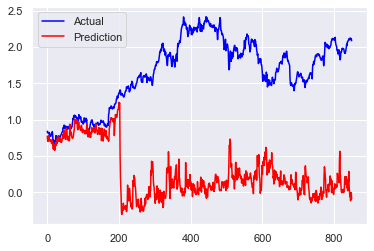

43/43 [==============================] - 0s 2ms/step - loss: 2.4689 - mse: 2.4689
[2.468909740447998, 2.468909740447998]


In [19]:
scaler = StandardScaler()
scaler.fit(data41)
data41 = scaler.transform(data41)
    
X = np.array(data41[:, :])
y = np.array(data41[:, -1:])
       
look_back = 5
batch_size = 20

X_train0, X_test, y_train0, y_test = train_test_split(X, y,
                                             train_size=0.8, 
                                             shuffle=False)
    
X_train, X_val , y_train, y_val = train_test_split(X_train0, y_train0,
                                             train_size=0.8, 
                                             shuffle=False)

    
train_data_gen = TimeseriesGenerator(X_train, y_train, length=look_back, batch_size=batch_size)
    
val_data_gen = TimeseriesGenerator(X_val, y_val, length=look_back, batch_size=batch_size)
    
test_data_gen = TimeseriesGenerator(X_test, y_test, length=look_back, batch_size=batch_size)

history = model4.fit_generator(train_data_gen,
                                  steps_per_epoch=len(train_data_gen),
                                  epochs=20,
                                  verbose=1,
                                  validation_data=val_data_gen) 
    
y_pred_test = model4.predict(test_data_gen)
c = pd.concat([pd.DataFrame(y_pred_test), pd.DataFrame(y_test[look_back:])], axis=1)
c.columns = ['pred', 'actual']
pred = c.iloc[:, 0]
actual = c.iloc[:, 1]
plt.plot(actual, color='blue', label='Actual')
plt.plot(pred, color='red', label='Prediction')

plt.legend(loc='upper left')
plt.show()
print(model4.evaluate(test_data_gen))

## the prediction result is bad

# use return data to directly predict AAPL future return

In [20]:
ticker = ["AAPL", "SPY"]
index_ticker = "XLY"
dateAttr = "Dt"
priceAttr = ["Adj Close", 'Volume', 'High', 'Low', 'Open']

data4 = helper.getData(ticker, index_ticker, priceAttr)
data4 = data4.join(data3[['Adj Close_CSCO', 'Adj Close_INTC']], how='left')
data4['Return_AAPL'] = data4['AAPL_Adj_Close'].pct_change()
data4 = data4.dropna()
data4

,AAPL_Adj_Close,AAPL_High,AAPL_Low,AAPL_Open,AAPL_Volume,SPY_Adj_Close,SPY_High,SPY_Low,SPY_Open,SPY_Volume,XLY_Adj_Close,XLY_High,XLY_Low,XLY_Open,XLY_Volume,Adj Close_CSCO,Adj Close_INTC,Return_AAPL
Dt,,,,,,,,,,,,,,,,,,
2000-01-04,3.1852,110.6250,101.188,108.2500,128094400.0,96.5415,144.0630,139.641,143.531,8089800.0,22.8930,29.8130,29.0310,29.6880,177200.0,-0.056102,-0.046695,-0.084318
2000-01-05,3.2318,110.5630,103.000,103.7500,194580400.0,96.7142,141.5284,137.250,139.938,12177900.0,22.6114,29.3461,28.7190,29.3440,124600.0,-0.003065,0.008290,0.014630
2000-01-06,2.9521,107.0000,95.000,106.1183,191993200.0,95.1599,141.5000,137.750,139.625,6227200.0,22.8685,29.4060,28.9991,29.0470,135800.0,-0.016593,-0.058298,-0.086546
2000-01-07,3.0920,101.0000,95.500,96.5000,115183600.0,100.6864,145.7500,140.063,140.313,8066500.0,23.9458,30.5630,29.5000,29.5000,70000.0,0.058751,0.041270,0.047390
2000-01-10,3.0376,102.2500,94.750,102.0000,126266000.0,101.0318,146.9060,145.031,146.250,5741700.0,23.8234,30.5940,30.1560,30.5328,41900.0,0.037189,0.045732,-0.017594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,111.3073,116.5255,115.590,115.5900,14249500.0,214.2890,225.7200,225.210,225.430,36697800.0,79.5679,82.7650,82.3510,82.6100,2837000.0,0.002299,0.001083,0.001978
2016-12-27,112.0142,117.8000,116.490,116.5200,18296900.0,214.8206,226.7300,226.000,226.020,42672500.0,79.8767,83.1000,82.5100,82.5100,6101100.0,0.004914,0.002706,0.006351
2016-12-28,111.5366,118.0170,116.200,117.5200,20905900.0,213.0452,226.5900,224.270,226.570,64095000.0,79.3267,83.0300,82.1800,82.9500,3857700.0,-0.008474,-0.011872,-0.004264


In [21]:
model4 = Sequential()
model4.add(LSTM(16, activation='relu', return_sequences=False))
model4.add(Dense(1, activation='linear'))


model4.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

StandardScaler()

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_10800/864419918.py:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model4.fit_generator(train_data_gen,


Epoch 1/20
137/137 [==============================] - 2s 5ms/step - loss: 1.3521 - mse: 1.3521 - val_loss: 0.6474 - val_mse: 0.6474
Epoch 2/20
137/137 [==============================] - 0s 3ms/step - loss: 1.3318 - mse: 1.3318 - val_loss: 0.6795 - val_mse: 0.6795
Epoch 3/20
137/137 [==============================] - 0s 3ms/step - loss: 1.3236 - mse: 1.3236 - val_loss: 0.6295 - val_mse: 0.6295
Epoch 4/20
137/137 [==============================] - 0s 3ms/step - loss: 1.3174 - mse: 1.3174 - val_loss: 0.6731 - val_mse: 0.6731
Epoch 5/20
137/137 [==============================] - 0s 3ms/step - loss: 1.3122 - mse: 1.3122 - val_loss: 0.6073 - val_mse: 0.6073
Epoch 6/20
137/137 [==============================] - 0s 3ms/step - loss: 1.3092 - mse: 1.3092 - val_loss: 0.5661 - val_mse: 0.5661
Epoch 7/20
137/137 [==============================] - 0s 3ms/step - loss: 1.3064 - mse: 1.3064 - val_loss: 0.6179 - val_mse: 0.6179
Epoch 8/20
137/137 [==============================] - 0s 3ms/step - loss: 1.

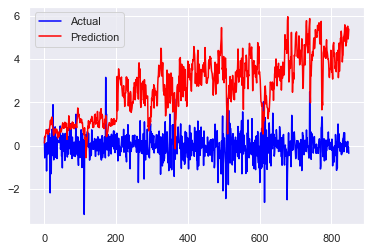

43/43 [==============================] - 0s 2ms/step - loss: 9.9688 - mse: 9.9688
[9.968790054321289, 9.968790054321289]


In [22]:
scaler = StandardScaler()
scaler.fit(data4)
data4 = scaler.transform(data4)

    
X = np.array(data4[:, :])
y = np.array(data4[:, -1:])
       
look_back = 5
batch_size = 20

X_train0, X_test, y_train0, y_test = train_test_split(X, y,
                                             train_size=0.8, 
                                             shuffle=False)
    
X_train, X_val , y_train, y_val = train_test_split(X_train0, y_train0,
                                             train_size=0.8, 
                                             shuffle=False)

    
train_data_gen = TimeseriesGenerator(X_train, y_train, length=look_back, batch_size=batch_size)
    
val_data_gen = TimeseriesGenerator(X_val, y_val, length=look_back, batch_size=batch_size)
    
test_data_gen = TimeseriesGenerator(X_test, y_test, length=look_back, batch_size=batch_size)

history = model4.fit_generator(train_data_gen,
                                  steps_per_epoch=len(train_data_gen),
                                  epochs=20,
                                  verbose=1,
                                  validation_data=val_data_gen) 
    
y_pred_test = model4.predict(test_data_gen)
c = pd.concat([pd.DataFrame(y_pred_test), pd.DataFrame(y_test[look_back:])], axis=1)
c.columns = ['pred', 'actual']
pred = c.iloc[:, 0]
actual = c.iloc[:, 1]
plt.plot(actual, color='blue', label='Actual')
plt.plot(pred, color='red', label='Prediction')

plt.legend(loc='upper left')
plt.show()
print(model4.evaluate(test_data_gen))

In [23]:
# calculate MSE 
mse = mean_squared_error(actual,pred)
# calculate RMSE 
rmse = math.sqrt(mean_squared_error(actual, pred))

print('MSE: %.6f' % mse)
print('RMSE: %.6f' % rmse)

MSE: 9.968788
RMSE: 3.157339


## the prediction result is bad, may be because the features are too many, so pca is applied to get the main features

# apply pca

In [34]:
ticker = ["AAPL", "SPY"]
index_ticker = "XLY"
dateAttr = "Dt"
priceAttr = ["Adj Close", 'Volume', 'High', 'Low', 'Open']

data4 = helper.getData(ticker, index_ticker, priceAttr)
data4 = data4.join(data3[['Adj Close_CSCO', 'Adj Close_INTC']], how='left')
data4['Return_AAPL'] = data4['AAPL_Adj_Close'].pct_change()
data4 = data4.dropna()
data4

,AAPL_Adj_Close,AAPL_High,AAPL_Low,AAPL_Open,AAPL_Volume,SPY_Adj_Close,SPY_High,SPY_Low,SPY_Open,SPY_Volume,XLY_Adj_Close,XLY_High,XLY_Low,XLY_Open,XLY_Volume,Adj Close_CSCO,Adj Close_INTC,Return_AAPL
Dt,,,,,,,,,,,,,,,,,,
2000-01-04,3.1852,110.6250,101.188,108.2500,128094400.0,96.5415,144.0630,139.641,143.531,8089800.0,22.8930,29.8130,29.0310,29.6880,177200.0,-0.056102,-0.046695,-0.084318
2000-01-05,3.2318,110.5630,103.000,103.7500,194580400.0,96.7142,141.5284,137.250,139.938,12177900.0,22.6114,29.3461,28.7190,29.3440,124600.0,-0.003065,0.008290,0.014630
2000-01-06,2.9521,107.0000,95.000,106.1183,191993200.0,95.1599,141.5000,137.750,139.625,6227200.0,22.8685,29.4060,28.9991,29.0470,135800.0,-0.016593,-0.058298,-0.086546
2000-01-07,3.0920,101.0000,95.500,96.5000,115183600.0,100.6864,145.7500,140.063,140.313,8066500.0,23.9458,30.5630,29.5000,29.5000,70000.0,0.058751,0.041270,0.047390
2000-01-10,3.0376,102.2500,94.750,102.0000,126266000.0,101.0318,146.9060,145.031,146.250,5741700.0,23.8234,30.5940,30.1560,30.5328,41900.0,0.037189,0.045732,-0.017594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,111.3073,116.5255,115.590,115.5900,14249500.0,214.2890,225.7200,225.210,225.430,36697800.0,79.5679,82.7650,82.3510,82.6100,2837000.0,0.002299,0.001083,0.001978
2016-12-27,112.0142,117.8000,116.490,116.5200,18296900.0,214.8206,226.7300,226.000,226.020,42672500.0,79.8767,83.1000,82.5100,82.5100,6101100.0,0.004914,0.002706,0.006351
2016-12-28,111.5366,118.0170,116.200,117.5200,20905900.0,213.0452,226.5900,224.270,226.570,64095000.0,79.3267,83.0300,82.1800,82.9500,3857700.0,-0.008474,-0.011872,-0.004264


StandardScaler()

5 has a cumulative explained variane of: 0.9258089769729368


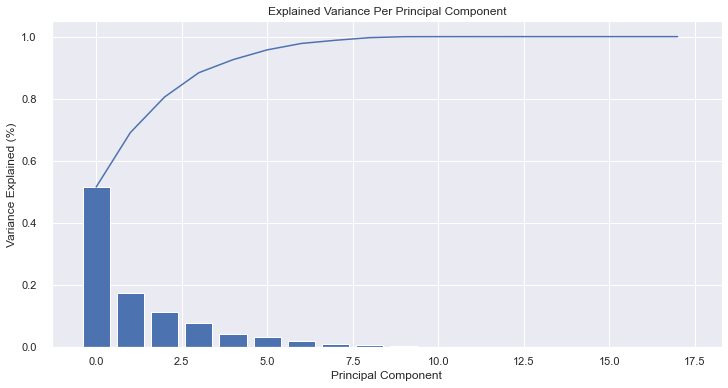

In [35]:
def scree_plot(pca_estimator):
    num_components = len(pca_estimator.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca_estimator.explained_variance_ratio_
 
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
pca = PCA(n_components = 18)
scaler = StandardScaler()
scaler.fit(data4)
scaled_data4 = scaler.transform(data4)
data4_pca = pca.fit_transform(scaled_data4)

scree_plot(pca)

n = 5
print(f'{n} has a cumulative explained variane of: {sum(pca.explained_variance_ratio_[:n])}')

# use price data to predict AAPL future price first, and then calculate percent change to get AAPL future return

In [65]:
pca_df = pd.DataFrame(data4_pca[:, :5], index=data4.index)
#data5 = pca_df.join(data4.iloc[:, -1])
data5 = pca_df.join(data4['AAPL_Adj_Close'])
data5

,0,1,2,3,4,AAPL_Adj_Close
Dt,,,,,,
2000-01-04,-1.418037,-0.917193,-4.218241,-1.198429,0.578057,3.1852
2000-01-05,-1.600640,-0.904319,0.433541,-0.445271,1.234142,3.2318
2000-01-06,-1.603056,-0.816984,-3.655775,-0.854694,1.012551,2.9521
2000-01-07,-1.376637,-1.286563,3.365817,-0.518504,0.514284,3.0920
2000-01-10,-1.239999,-1.255572,1.615836,-0.643333,0.407729,3.0376
...,...,...,...,...,...,...
2016-12-23,6.759554,-2.877184,-0.009900,-0.002230,0.077767,111.3073
2016-12-27,6.914393,-2.592650,0.149660,0.418635,-0.207036,112.0142
2016-12-28,6.799901,-2.653331,-0.733080,0.217612,0.023513,111.5366


# Model Building -Single layer

In [80]:
model = Sequential()
model.add(LSTM(24, activation='relu', return_sequences=False, input_shape=(10, len(data5.columns))))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))


model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

Epoch 1/20
24/55 [============>.................] - ETA: 0s - loss: 0.2098 - mse: 0.2098

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_4752/43118769.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data_gen,


55/55 [==============================] - 0s 7ms/step - loss: 0.3746 - mse: 0.3746 - val_loss: 6.6308 - val_mse: 6.6308
Epoch 2/20
55/55 [==============================] - 0s 5ms/step - loss: 0.3739 - mse: 0.3739 - val_loss: 4.9886 - val_mse: 4.9886
Epoch 3/20
55/55 [==============================] - 0s 6ms/step - loss: 0.2009 - mse: 0.2009 - val_loss: 2.9083 - val_mse: 2.9083
Epoch 4/20
55/55 [==============================] - 0s 5ms/step - loss: 0.2006 - mse: 0.2006 - val_loss: 3.4902 - val_mse: 3.4902
Epoch 5/20
55/55 [==============================] - 0s 5ms/step - loss: 0.2332 - mse: 0.2332 - val_loss: 4.1097 - val_mse: 4.1097
Epoch 6/20
55/55 [==============================] - 0s 5ms/step - loss: 0.1924 - mse: 0.1924 - val_loss: 4.7543 - val_mse: 4.7543
Epoch 7/20
55/55 [==============================] - 0s 5ms/step - loss: 0.1779 - mse: 0.1779 - val_loss: 10.3757 - val_mse: 10.3757
Epoch 8/20
55/55 [==============================] - 0s 5ms/step - loss: 0.2371 - mse: 0.2371 - val_

,pred,actual
0,64.727493,64.2836
1,64.735664,62.4457
2,64.027779,62.7410
3,64.479362,62.8432
4,64.747757,62.2707
...,...,...
840,104.793053,111.3073
841,105.090172,112.0142
842,105.305351,111.5366
843,105.208107,111.5079


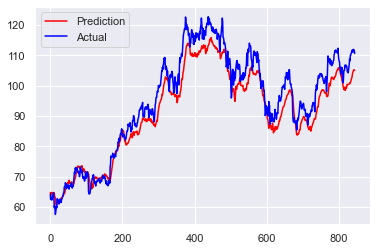

In [88]:
X = np.array(data5.iloc[:, :])
y = np.array(data5.iloc[:, -1:])

look_back = 10
batch_size = 50

X_train0, X_test, y_train0, y_test = train_test_split(X, y,train_size=0.8, shuffle=False)

X_train, X_val , y_train, y_val = train_test_split(X_train0, y_train0,train_size=0.8, shuffle=False)

train_data_gen = TimeseriesGenerator(X_train, y_train, length=look_back, batch_size=batch_size)
val_data_gen = TimeseriesGenerator(X_val, y_val, length=look_back, batch_size=batch_size)
test_data_gen = TimeseriesGenerator(X_test, y_test, length=look_back, batch_size=batch_size)


history = model.fit_generator(train_data_gen,
                                steps_per_epoch=len(train_data_gen),
                                epochs=20,
                                verbose=1,
                                validation_data=val_data_gen) 
    
    
y_pred_test = model.predict(test_data_gen)
c = pd.concat([pd.DataFrame(y_pred_test), pd.DataFrame(y_test[look_back:])], axis=1)
c.columns = ['pred', 'actual']
c
pred = c.iloc[:, 0]
actual = c.iloc[:, 1]
plt.plot(pred, color='red', label='Prediction')
plt.plot(actual, color='blue', label='Actual')
plt.legend(loc='upper left')

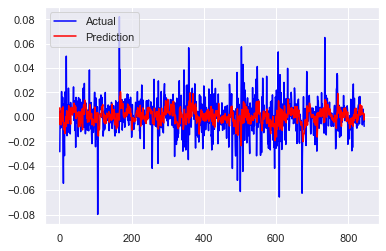

In [71]:
c = pd.concat([pd.DataFrame(y_pred_test), pd.DataFrame(y_test[look_back:])], axis=1)
c_rt = c.pct_change().dropna()
c_rt.columns = ['pred', 'actual']
pred = c_rt.iloc[:, 0]
actual = c_rt.iloc[:, 1]
plt.plot(actual, color='blue', label='Actual')
plt.plot(pred, color='red', label='Prediction')
plt.legend(loc='upper left')
plt.show()

In [58]:
# calculate MSE 
mse = mean_squared_error(actual,pred)
# calculate RMSE 
rmse = math.sqrt(mean_squared_error(actual, pred))

print('MSE: %.6f' % mse)
print('RMSE: %.6f' % rmse)

MSE: 0.000372
RMSE: 0.019291


# Model Building -Multi layer

In [72]:
model5 = Sequential()
model5.add(LSTM(24, activation='relu', return_sequences=True, input_shape=(10, len(data5.columns))))
model5.add(LSTM(12, activation='relu', return_sequences=False, input_shape=(10, 24)))
model5.add(Dense(32, activation='relu'))
model5.add(Dense(16, activation='relu'))
model5.add(Dense(8, activation='relu'))
model5.add(Dense(1, activation='linear'))


model5.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

Epoch 1/20
13/55 [======>.......................] - ETA: 0s - loss: 35.2205 - mse: 35.2205

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_4752/2063618195.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model5.fit_generator(train_data_gen,


55/55 [==============================] - 1s 10ms/step - loss: 19.8465 - mse: 19.8465 - val_loss: 60.1948 - val_mse: 60.1948
Epoch 2/20
55/55 [==============================] - 1s 10ms/step - loss: 1.7172 - mse: 1.7172 - val_loss: 21.6616 - val_mse: 21.6616
Epoch 3/20
55/55 [==============================] - 1s 10ms/step - loss: 0.4723 - mse: 0.4723 - val_loss: 8.6118 - val_mse: 8.6118
Epoch 4/20
55/55 [==============================] - 0s 8ms/step - loss: 0.3447 - mse: 0.3447 - val_loss: 7.3496 - val_mse: 7.3496
Epoch 5/20
55/55 [==============================] - 0s 9ms/step - loss: 0.2966 - mse: 0.2966 - val_loss: 7.7538 - val_mse: 7.7538
Epoch 6/20
55/55 [==============================] - 0s 8ms/step - loss: 0.2353 - mse: 0.2353 - val_loss: 5.6693 - val_mse: 5.6693
Epoch 7/20
55/55 [==============================] - 0s 9ms/step - loss: 0.2057 - mse: 0.2057 - val_loss: 5.1364 - val_mse: 5.1364
Epoch 8/20
55/55 [==============================] - 0s 9ms/step - loss: 0.1875 - mse: 0.1875

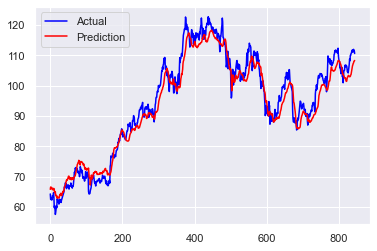

In [79]:
X = np.array(data5.iloc[:, :])
y = np.array(data5.iloc[:, -1:])

look_back = 10
batch_size = 50

X_train0, X_test, y_train0, y_test = train_test_split(X, y,train_size=0.8, shuffle=False)

X_train, X_val , y_train, y_val = train_test_split(X_train0, y_train0,train_size=0.8, shuffle=False)

train_data_gen = TimeseriesGenerator(X_train, y_train, length=look_back, batch_size=batch_size)
val_data_gen = TimeseriesGenerator(X_val, y_val, length=look_back, batch_size=batch_size)
test_data_gen = TimeseriesGenerator(X_test, y_test, length=look_back, batch_size=batch_size)


history = model5.fit_generator(train_data_gen,
                                steps_per_epoch=len(train_data_gen),
                                epochs=20,
                                verbose=1,
                                validation_data=val_data_gen) 
    
    
y_pred_test = model5.predict(test_data_gen)
c = pd.concat([pd.DataFrame(y_pred_test), pd.DataFrame(y_test[look_back:])], axis=1)
c.columns = ['pred', 'actual']
pred = c.iloc[:, 0]
actual = c.iloc[:, 1]
plt.plot(actual, color='blue', label='Actual')
plt.plot(pred, color='red', label='Prediction')
plt.legend(loc='upper left')
plt.show()

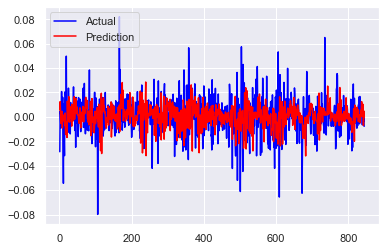

In [61]:
c = pd.concat([pd.DataFrame(y_pred_test), pd.DataFrame(y_test[look_back:])], axis=1)
c_rt = c.pct_change().dropna()
c_rt.columns = ['pred', 'actual']
pred = c_rt.iloc[:, 0]
actual = c_rt.iloc[:, 1]
plt.plot(actual, color='blue', label='Actual')
plt.plot(pred, color='red', label='Prediction')
plt.legend(loc='upper left')
plt.show()

In [30]:
# calculate MSE 
mse = mean_squared_error(actual,pred)
# calculate RMSE 
rmse = math.sqrt(mean_squared_error(actual, pred))

print('MSE: %.6f' % mse)
print('RMSE: %.6f' % rmse)

MSE: 0.165845
RMSE: 0.407241


## the prediction result is good

# use return data to directly predict AAPL future return

In [48]:
pca_df = pd.DataFrame(data4_pca[:, :5], index=data4.index)
data6 = pca_df.join(data4.iloc[:, -1])
#data5 = pca_df.join(data4['AAPL_Adj_Close'])
data6

,0,1,2,3,4,Return_AAPL
Dt,,,,,,
2000-01-04,-1.418037,-0.917193,-4.218241,-1.198429,0.578057,-0.084318
2000-01-05,-1.600640,-0.904319,0.433541,-0.445271,1.234142,0.014630
2000-01-06,-1.603056,-0.816984,-3.655775,-0.854694,1.012551,-0.086546
2000-01-07,-1.376637,-1.286563,3.365817,-0.518504,0.514284,0.047390
2000-01-10,-1.239999,-1.255572,1.615836,-0.643333,0.407729,-0.017594
...,...,...,...,...,...,...
2016-12-23,6.759554,-2.877184,-0.009900,-0.002230,0.077767,0.001978
2016-12-27,6.914393,-2.592650,0.149660,0.418635,-0.207036,0.006351
2016-12-28,6.799901,-2.653331,-0.733080,0.217612,0.023513,-0.004264


# Model Building -single layer

In [52]:
model61 = Sequential()
model61.add(LSTM(24, activation='relu', return_sequences=False, input_shape=(10, len(data5.columns))))
model61.add(Dense(32, activation='relu'))
model61.add(Dense(16, activation='relu'))
model61.add(Dense(8, activation='relu'))
model61.add(Dense(1, activation='linear'))


model61.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_4752/920422766.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model61.fit_generator(train_data_gen,


Epoch 1/20
55/55 [==============================] - 2s 9ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 2/20
55/55 [==============================] - 0s 5ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 3/20
55/55 [==============================] - 0s 6ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 4/20
55/55 [==============================] - 0s 6ms/step - loss: 9.5613e-04 - mse: 9.5613e-04 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 5/20
55/55 [==============================] - 0s 5ms/step - loss: 9.0840e-04 - mse: 9.0840e-04 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 6/20
55/55 [==============================] - 0s 5ms/step - loss: 8.9625e-04 - mse: 8.9625e-04 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 7/20
55/55 [==============================] - 0s 5ms/step - loss: 8.7886e-04 - mse: 8.7886e-04 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 8/20
55/55 [==============================] - 0s 7ms

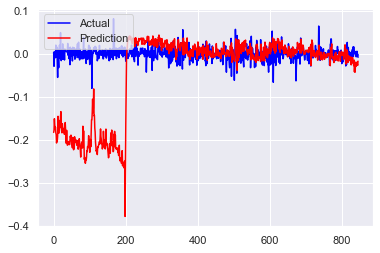

In [53]:
X = np.array(data6.iloc[:, :])
y = np.array(data6.iloc[:, -1:])

look_back = 10
batch_size = 50

X_train0, X_test, y_train0, y_test = train_test_split(X, y,
                                            train_size=0.8, 
                                            shuffle=False)

X_train, X_val , y_train, y_val = train_test_split(X_train0, y_train0,
                                            train_size=0.8, 
                                            shuffle=False)

train_data_gen = TimeseriesGenerator(X_train, y_train, length=look_back, batch_size=batch_size)
val_data_gen = TimeseriesGenerator(X_val, y_val, length=look_back, batch_size=batch_size)
test_data_gen = TimeseriesGenerator(X_test, y_test, length=look_back, batch_size=batch_size)


history = model61.fit_generator(train_data_gen,
                                steps_per_epoch=len(train_data_gen),
                                epochs=20,
                                verbose=1,
                                validation_data=val_data_gen) 
    
    
y_pred_test = model61.predict(test_data_gen)
c = pd.concat([pd.DataFrame(y_pred_test), pd.DataFrame(y_test[look_back:])], axis=1)
c.columns = ['pred', 'actual']
pred = c.iloc[:, 0]
actual = c.iloc[:, 1]
plt.plot(actual, color='blue', label='Actual')
plt.plot(pred, color='red', label='Prediction')
plt.legend(loc='upper left')
plt.show()

# Model Building -multi layer

In [32]:
model6 = Sequential()
model6.add(LSTM(24, activation='relu', return_sequences=True, input_shape=(10, len(data6.columns))))
model6.add(LSTM(12, activation='relu', return_sequences=False, input_shape=(10, 24)))
model6.add(Dense(32, activation='relu'))
model6.add(Dense(16, activation='relu'))
model6.add(Dense(8, activation='relu'))
model6.add(Dense(1, activation='linear'))


model6.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_10800/254037780.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model6.fit_generator(train_data_gen,


Epoch 1/20
55/55 [==============================] - 3s 14ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 3.9800e-04 - val_mse: 3.9800e-04
Epoch 2/20
55/55 [==============================] - 0s 8ms/step - loss: 8.7550e-04 - mse: 8.7550e-04 - val_loss: 3.8553e-04 - val_mse: 3.8553e-04
Epoch 3/20
55/55 [==============================] - 0s 8ms/step - loss: 8.6324e-04 - mse: 8.6324e-04 - val_loss: 5.2270e-04 - val_mse: 5.2270e-04
Epoch 4/20
55/55 [==============================] - 0s 8ms/step - loss: 8.6028e-04 - mse: 8.6028e-04 - val_loss: 8.4268e-04 - val_mse: 8.4268e-04
Epoch 5/20
55/55 [==============================] - 0s 8ms/step - loss: 8.6065e-04 - mse: 8.6065e-04 - val_loss: 7.8147e-04 - val_mse: 7.8147e-04
Epoch 6/20
55/55 [==============================] - 0s 8ms/step - loss: 8.5737e-04 - mse: 8.5737e-04 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 7/20
55/55 [==============================] - 0s 8ms/step - loss: 8.5622e-04 - mse: 8.5622e-04 - val_loss: 0.0017 - val_mse: 0.0017
E

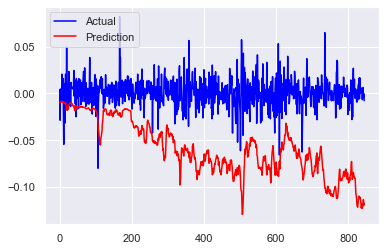

In [33]:
X = np.array(data6.iloc[:, :])
y = np.array(data6.iloc[:, -1:])

look_back = 10
batch_size = 50

X_train0, X_test, y_train0, y_test = train_test_split(X, y,
                                            train_size=0.8, 
                                            shuffle=False)

X_train, X_val , y_train, y_val = train_test_split(X_train0, y_train0,
                                            train_size=0.8, 
                                            shuffle=False)

train_data_gen = TimeseriesGenerator(X_train, y_train, length=look_back, batch_size=batch_size)
val_data_gen = TimeseriesGenerator(X_val, y_val, length=look_back, batch_size=batch_size)
test_data_gen = TimeseriesGenerator(X_test, y_test, length=look_back, batch_size=batch_size)


history = model6.fit_generator(train_data_gen,
                                steps_per_epoch=len(train_data_gen),
                                epochs=20,
                                verbose=1,
                                validation_data=val_data_gen) 
    
    
y_pred_test = model6.predict(test_data_gen)
c = pd.concat([pd.DataFrame(y_pred_test), pd.DataFrame(y_test[look_back:])], axis=1)
c.columns = ['pred', 'actual']
pred = c.iloc[:, 0]
actual = c.iloc[:, 1]
plt.plot(actual, color='blue', label='Actual')
plt.plot(pred, color='red', label='Prediction')
plt.legend(loc='upper left')
plt.show()

In [34]:
# calculate MSE 
mse = mean_squared_error(actual,pred)
# calculate RMSE 
rmse = math.sqrt(mean_squared_error(actual, pred))

print('MSE: %.6f' % mse)
print('RMSE: %.6f' % rmse)

MSE: 0.004579
RMSE: 0.067671


## the prediction result is not good compared to predict the price first

In [89]:
def saveModel(model, model_path): 
    try:
        os.makedirs(model_path)
    except OSError:
        print("Directory {dir:s} already exists, files will be over-written.".format(dir=model_path))
        
    # Save JSON config to disk
    json_config = model.to_json()
    with open(os.path.join(model_path, 'config.json'), 'w') as json_file:
        json_file.write(json_config)
    # Save weights to disk
    model.save_weights(os.path.join(model_path, 'weights.h5'))
    
    print("Model saved in directory {dir:s}; create an archive of this directory and submit with your assignment.".format(dir=model_path))
    
def loadModel(model_path):
    # Reload the model from the 2 files we saved
    with open(os.path.join(model_path, 'config.json')) as json_file:
        json_config = json_file.read()
    model = tf.keras.models.model_from_json(json_config)
    model.load_weights(os.path.join(model_path, 'weights.h5'))
    
    return model

def MyModel(test_dir, model_path):
    # YOU MAY NOT change model after this statement !
    model = loadModel(model_path)
    
    # It should run model to create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    
    # We need to match your array of predictions with the examples you are predicting
    # The array below (ids) should have a one-to-one correspondence and identify the example your are predicting
    # For Bankruptcy: the Id column
    # For Stock prediction: the date on which you are making a prediction
    ids = []
    
    # YOUR CODE GOES HERE
    file = os.path.join(test_dir, "AAPL.csv")
    data = pd.read_csv(file, index_col="Dt")
    data.drop(['Factor', 'Div'], axis=1, inplace=True)
    for column in data.columns:
        if len(column.split('_')) < 2:
            data.rename(columns={column: column + '_AAPL'}, inplace=True)
            
    file = os.path.join(test_dir, "SPY.csv")
    SPY = pd.read_csv(file, index_col="Dt")
    SPY.drop(['Factor', 'Div'], axis=1, inplace=True)
    data = data.join(SPY, how='left', rsuffix='_' + 'SPY')

    file = os.path.join(test_dir, "XLK.csv")
    XLK = pd.read_csv(file, index_col="Dt")
    XLK.drop(['Factor', 'Div'], axis=1, inplace=True)
    data = data.join(XLK, how='left', rsuffix='_' + 'XLK')
        
    for i in range(len(data.columns)):
        data.iloc[:, i] = data.iloc[:, i].pct_change()
    data.dropna(inplace=True)
    
    CSCO = pd.read_csv(test_dir + 'CSCO.csv', index_col="Dt")
    CSCO['Adj Close_CSCO'] = CSCO['Adj Close']
    CSCO_Price = CSCO['Adj Close_CSCO']
    data = data.join(CSCO_Price)
    
    
    INTC = pd.read_csv(test_dir + 'INTC.csv', index_col="Dt")
    INTC['Adj Close_INTC'] = INTC['Adj Close']
    INTC_Price = INTC['Adj Close_INTC']
    data = data.join(INTC_Price)
        
    data['AAPL_Adj_Return'] = data['Adj Close_AAPL']

    pca = PCA(n_components = 18)
    scaler = StandardScaler()
    scaler.fit(data)
    scaled_data = scaler.transform(data)
    data_pca = pca.fit_transform(scaled_data)
    data = pd.DataFrame(data_pca[:, :5], index=data.index)
    
    AAPL = pd.read_csv(test_dir + 'AAPL.csv', index_col="Dt")
    AAPL_Price = AAPL['Adj Close']
    data = data.join(AAPL_Price)
    
    X_test = np.array(data.iloc[:, :])
    y_test = np.array(data.iloc[:, -1:])
    test_data_gen = TimeseriesGenerator(X_test, y_test, length=10, batch_size=50)
    
    predictions = model.predict(test_data_gen)
    ids = np.array(data.index.to_list()[10:])
    
    return predictions, ids

# Assign to variable my_model the model that is your final model (the one  you will be evaluated on)
my_model = model # CHANGE None to your model !
modelName = 'final model1'
model_path = os.path.join(".", modelName)
saveModel(my_model, model_path)

Directory .\final model1 already exists, files will be over-written.
Model saved in directory .\final model1; create an archive of this directory and submit with your assignment.


# out of sample test

In [92]:
test_dir = './Data/sample/'
modelName = "final model"
model_path = os.path.join(".", modelName)
MyModel(test_dir, model_path)

(array([[113.74734 ],
        [114.63839 ],
        [115.07073 ],
        [115.51261 ],
        [115.37296 ],
        [115.0396  ],
        [115.07523 ],
        [114.30746 ],
        [115.42043 ],
        [114.26215 ],
        [115.80743 ],
        [117.63319 ],
        [119.54445 ],
        [118.736626],
        [120.80017 ],
        [123.30622 ],
        [124.136856],
        [118.69659 ],
        [122.41787 ],
        [127.50063 ],
        [125.63766 ],
        [123.85862 ],
        [125.121185],
        [126.550026],
        [126.941216],
        [126.80871 ],
        [128.20442 ],
        [129.019   ],
        [129.38167 ],
        [130.98495 ],
        [131.37363 ],
        [129.22647 ],
        [131.50996 ],
        [131.826   ],
        [132.17482 ],
        [133.7403  ],
        [133.57007 ],
        [133.59888 ],
        [134.41064 ],
        [134.28214 ],
        [134.41426 ],
        [132.33786 ],
        [133.96233 ],
        [133.11087 ],
        [134.5746  ],
        [1

<AxesSubplot:>

MSE:  4.44067235009561


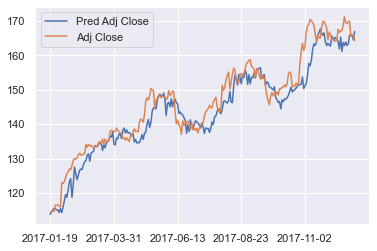

In [93]:
price, date = MyModel(test_dir, model_path)
df = pd.DataFrame(price, index=date, columns=['Pred Adj Close'])
df1 = pd.read_csv(test_dir + 'AAPL.csv', index_col="Dt")
df = df.join(df1['Adj Close'], how = 'left')
df.plot()
df['diff'] = df['Pred Adj Close'] - df['Adj Close']
df['diff2'] = df['diff'] ** 2
print('MSE: ', np.sqrt(df['diff2'].sum() / len(df)))

In [39]:
print("Done")

Done
